# Multilayer Perceptron

### Libraries and Variables

In [30]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch import nn
import torch.nn.functional as nnf

home_dir = os.path.expanduser('~')
raw_data_dir = os.path.join(home_dir, 'repos/DaNuMa2024/data/raw_data')

### Overview

In this notebook, you will implement and train the simplest neural network architecture there is: a multilayer perceptron. You will see how it is able to solve non-linear function approximation problems. Also, you will demonstrate the advantage of validation during model training to prevent overfitting.

# Data

First, we load the toy dataset we use for model training and validation:

In [78]:
train_path = os.path.join(raw_data_dir, '3_mlp/train.csv')
val_path = os.path.join(raw_data_dir, '3_mlp/val.csv')

train_data = pd.read_csv(train_path, header=None)
val_data = pd.read_csv(val_path, header=None)

x_train = train_data.iloc[:, 0].to_numpy()
y_train = train_data.iloc[:, 1].to_numpy()
x_val = val_data.iloc[:, 0].to_numpy()
y_val = val_data.iloc[:, 1].to_numpy()

In [79]:
val_data
df_sampled = val_data.sample(n=24)
df_sampled.to_csv('/user/henrich1/u12112/repos/DaNuMa2024/data/raw_data/3_mlp/val_sampled.csv', index=False, header=False)

x_val = df_sampled.iloc[:, 0].to_numpy()
y_val = df_sampled.iloc[:, 1].to_numpy()

Visualize the data! It is a little bit unusual that our training dataset is smaller than the validation dataset. This is done for demonstration purposes and usually not to be recommended in practice.

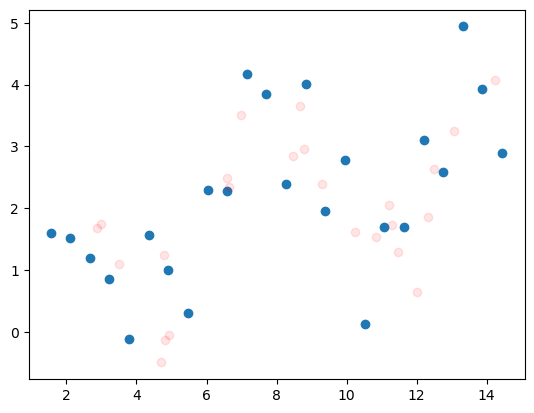

In [80]:
######### YOUR CODE HERE:
plt.scatter(x_train, y_train)
plt.scatter(x_val, y_val, c='red', alpha=0.1)

# Dataset and model

Now define the dataset that loads the x and y values as tuples. The dataset is usually the point where other data types are transformed to tensors. \
Remember that a dataset must have a constructor as it is an object (\_\_init\_\_) as well as a \_\_len\_\_ and \_\_getitem\_\_ function.

In [81]:
####################### dataset
class MLPDataset(Dataset):
    ######### YOUR CODE HERE:
    def __init__(self, x, y):
        self.x = torch.from_numpy(x)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

Now define the MLP. The layer sizes should be [1, 32, 64, 128, 256, 128, 64, 32, 1]. The 1 at the beginning and end denote the input and output size of the model, which is one-dimensional in our case. The numbers in-between denote the hidden layer sizes. So the network has 7 hidden layers. \
Bonus: If you want to define the network more elegantly, you can also pass the layer sizes to the constructor and define the network dynamically based on what layer sizes you provide as an argument to the network. You can make use of a loop together with a list and nn.Sequential to define the layers this way.

In [82]:
####################### model

########### elegant solution
class MLP(nn.Module):
    ######### YOUR CODE HERE:
    def __init__(self, layer_sizes):
        super().__init__()

        modules = []
        for i in range(len(layer_sizes)-1):
            modules.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))

            if not i == len(layer_sizes)-2:
                modules.append(nn.ReLU())

        self.layers = nn.Sequential(*modules)


    def forward(self, x):
        return self.layers(x)
    
########### straight-forward solution
# class MLP(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.linear1 = nn.Linear(1, 32)
#         self.linear2 = nn.Linear(32, 64)
#         self.linear3 = nn.Linear(64, 128)
#         self.linear4 = nn.Linear(128, 256)
#         self.linear5 = nn.Linear(256, 128)
#         self.linear6 = nn.Linear(128, 64)
#         self.linear7 = nn.Linear(64, 32)
#         self.linear8 = nn.Linear(32, 1)

#         self.relu = nn.ReLU()


#     def forward(self, x):
#         x = self.linear1(x)
#         x = self.relu(x)
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.linear3(x)
#         x = self.relu(x)
#         x = self.linear4(x)
#         x = self.relu(x)
#         x = self.linear5(x)
#         x = self.relu(x)
#         x = self.linear6(x)
#         x = self.relu(x)
#         x = self.linear7(x)
#         x = self.relu(x)
#         x = self.linear8(x)
#         return x

# Training loop

Implement as simple training loop without validation. Use the mean squared error as a loss function (mse_loss) and AdamW as the optimizer. Store the average loss in every epoch in a list so that you can later plot it.

In [83]:
####################### Training loop without validation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"The model is running on {device}.")

# training parameters
epochs = 4000
batch_size = 24
lr = 0.001

# instantiate dataset and dataloader
######### YOUR CODE HERE:
trainset = MLPDataset(x_train, y_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# instantiate model and optimizer
######### YOUR CODE HERE:
layer_sizes = [1, 32, 64, 128, 256, 128, 64, 32, 1]
model = MLP(layer_sizes=layer_sizes).to(device)
optimizer = AdamW(model.parameters(), lr=lr)

# training loop
all_train_losses = []
for epoch in tqdm(range(epochs)):
    ######### YOUR CODE HERE:
    model.train()
    train_losses = []
    for x_batch, y_batch in trainloader:
        x_batch = x_batch[:, None].float().to(device)
        y_batch = y_batch[:, None].float().to(device)
        y_pred = model(x_batch)

        optimizer.zero_grad()
        loss = nnf.mse_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    train_loss_epoch = sum(train_losses) / len(train_losses)
    all_train_losses.append(train_loss_epoch)

The model is running on cpu.


100%|██████████| 4000/4000 [00:21<00:00, 184.09it/s]


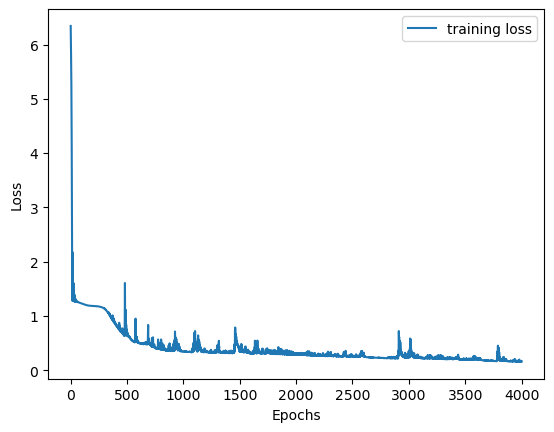

In [84]:
####################### plot training losses
######### YOUR CODE HERE:
plt.plot(np.arange(1, epochs+1, 1), all_train_losses, label='training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Now plot the data together with the predictions (hint: you can use the torch.linspace function to create a sequence of x values for which to generate model predictions for plotting). \
What do you observe? Is the model you obtained in the last epoch a good approximation for the underlying function?

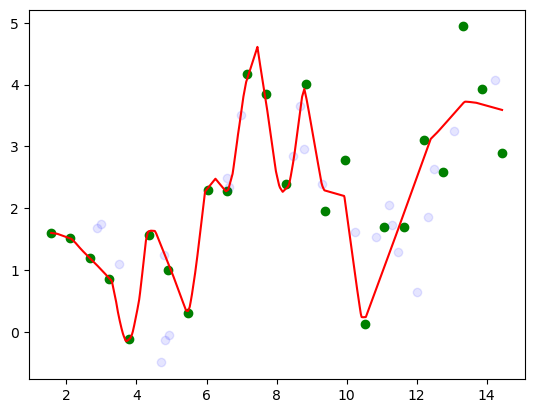

In [86]:
####################### plot predictions together with the data (hint: you can use the torch.linspace function to create a sequence of x values for which to generate model predictions for plotting)
######### YOUR CODE HERE:
plt.scatter(x_train, y_train, c='green')
plt.scatter(x_val, y_val, c='blue', alpha=0.1)

min_x = np.min(x_train)
max_x = np.max(x_train)
x_seq = torch.linspace(min_x, max_x, 1000)[:, None].to(device)
model.eval()
with torch.no_grad():
    y_seq = model(x_seq)
plt.plot(x_seq.cpu(), y_seq.cpu(), c='r')

# The model overfits heavily to the training data. The predicted function is not a good approximation of the general underlying function.

# Training loop with validation

In [104]:
####################### Training loop without validation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"The model is running on {device}.")

# training parameters
epochs = 4000
batch_size = 32
lr = 0.001
layer_sizes = [1, 32, 64, 128, 256, 128, 64, 32, 1]

# training objects
trainset = MLPDataset(x_train, y_train)
valset = MLPDataset(x_val, y_val)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)
model = MLP(layer_sizes=layer_sizes).to(device)
optimizer = AdamW(model.parameters(), lr=lr)

# training loop
train_losses = []
val_losses = []
min_val_loss = float('inf')
for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0

    # training
    for x_batch, y_batch in trainloader:
        x_batch = x_batch[:, None].float().to(device)
        y_batch = y_batch[:, None].float().to(device)
        y_pred = model(x_batch)

        optimizer.zero_grad()
        loss = nnf.mse_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss = train_loss / len(trainloader)
    train_losses.append(train_loss)

    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in valloader:
            x_batch = x_batch[:, None].float().to(device)
            y_batch = y_batch[:, None].float().to(device)
            y_pred = model(x_batch)
            loss = nnf.mse_loss(y_pred, y_batch)
            val_loss += loss.item()
    val_loss = val_loss / len(valloader)
    val_losses.append(val_loss)

    # save best model
    if val_loss < min_val_loss:
        torch.save(model.state_dict(), '/user/henrich1/u12112/repos/DaNuMa2024/data/output_data/best.pth')
        min_val_loss = val_loss

The model is running on cpu.


100%|██████████| 4000/4000 [00:26<00:00, 150.56it/s]


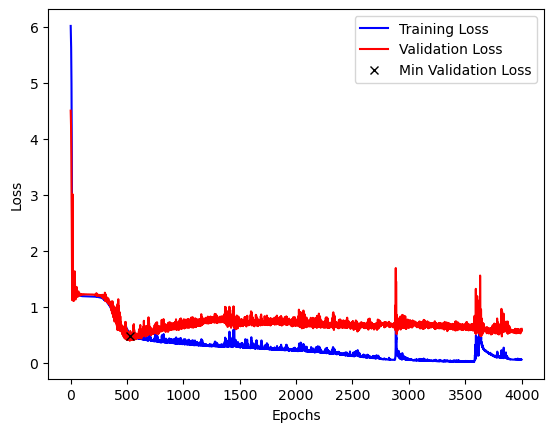

In [105]:
####################### plot losses
plt.plot(np.linspace(1, epochs, epochs), train_losses, c='blue', label='Training Loss')
plt.plot(np.linspace(1, epochs, epochs), val_losses, c='red', label='Validation Loss')

# Mark the minimum validation loss
min_val_index = np.argmin(val_losses)
plt.plot(min_val_index+1, val_losses[min_val_index+1], 'kx', label='Min Validation Loss')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


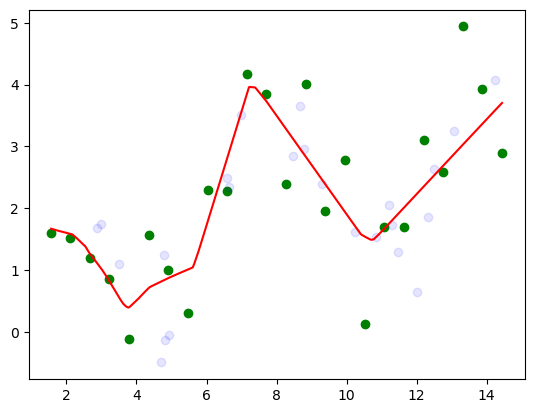

In [106]:
####################### plot predictions
plt.scatter(x_train, y_train, c='green')
plt.scatter(x_val, y_val, c='blue', alpha=0.1)


min_x = np.min(x_train)
max_x = np.max(x_train)
x_seq = torch.linspace(min_x, max_x, 1000)[:, None].to(device)
model.eval()
model.load_state_dict(torch.load('/user/henrich1/u12112/repos/DaNuMa2024/data/output_data/best.pth'))
with torch.no_grad():
    y_seq = model(x_seq)
plt.plot(x_seq.cpu(), y_seq.cpu(), c='r')

# Training loop with modular functions

In [109]:
def train(model, trainloader, valloader, optimizer, epochs, device, val_interval, savepath_best_statedict=None):
    train_losses = []
    val_losses = []
    min_val_loss = float('inf')

    for epoch in tqdm(range(epochs)):
        train_loss = train_one_epoch(model, trainloader, optimizer, device)
        train_losses.append(train_loss)

        if epoch % val_interval == 0:
            val_loss = validate(model, valloader, device)
            val_losses.append(val_loss)

        if savepath_best_statedict is not None:
            if val_loss < min_val_loss:
                torch.save(model.state_dict(), savepath_best_statedict)
                min_val_loss = val_loss
    return train_losses, val_losses

def train_one_epoch(model, trainloader, optimizer, device):
    model.train()
    total_loss = 0
    for x_batch, y_batch in trainloader:
        x_batch = x_batch[:, None].float().to(device)
        y_batch = y_batch[:, None].float().to(device)
        y_pred = model(x_batch)

        optimizer.zero_grad()
        loss = nnf.mse_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(trainloader)

def validate(model, valloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in valloader:
            x_batch = x_batch[:, None].float().to(device)
            y_batch = y_batch[:, None].float().to(device)
            y_pred = model(x_batch)
            loss = nnf.mse_loss(y_pred, y_batch)
            total_loss += loss.item()
    return total_loss / len(valloader)

In [110]:
####################### Training loop with modular definition of training and validation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"The model is running on {device}.")

# training parameters
epochs = 4000
batch_size = 32
lr = 0.001
layer_sizes = [1, 32, 64, 128, 256, 128, 64, 32, 1]
val_interval = 1

# training objects
trainset = MLPDataset(x_train, y_train)
valset = MLPDataset(x_val, y_val)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)
model = MLP(layer_sizes=layer_sizes).to(device)
optimizer = AdamW(model.parameters(), lr=lr)

# training
train_losses, val_losses = train(model, trainloader, valloader, optimizer, epochs, device, val_interval, savepath_best_statedict='/user/henrich1/u12112/repos/DaNuMa2024/data/output_data/best.pth')

The model is running on cpu.


100%|██████████| 4000/4000 [00:26<00:00, 152.54it/s]


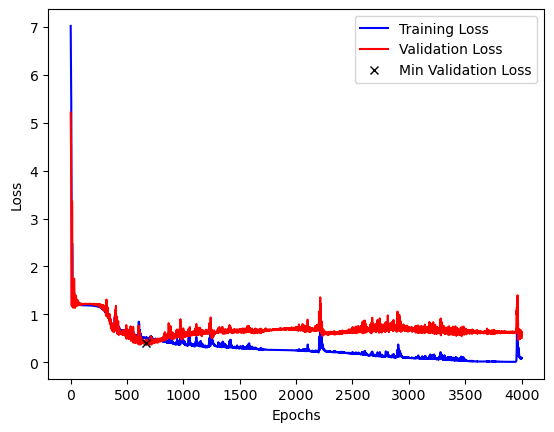

In [113]:
####################### plot losses
plt.plot(np.linspace(1, epochs, epochs), train_losses, c='blue', label='Training Loss')
plt.plot(np.linspace(1, epochs, epochs), val_losses, c='red', label='Validation Loss')

# Mark the minimum validation loss
min_val_index = np.argmin(val_losses)
plt.plot(min_val_index+1, val_losses[min_val_index+1], 'kx', label='Min Validation Loss')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


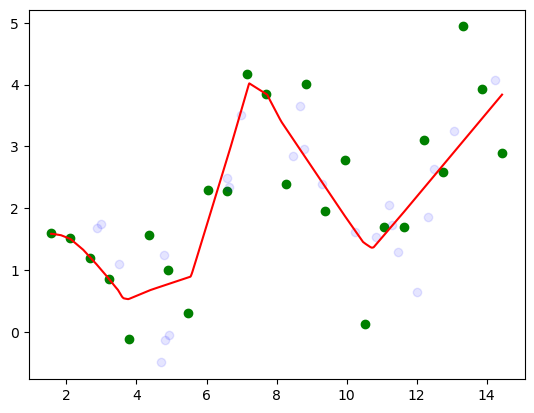

In [114]:
####################### plot predictions
plt.scatter(x_train, y_train, c='green')
plt.scatter(x_val, y_val, c='blue', alpha=0.1)

min_x = np.min(x_train)
max_x = np.max(x_train)
x_seq = torch.linspace(min_x, max_x, 1000)[:, None].to(device)
model.eval()
model.load_state_dict(torch.load('/user/henrich1/u12112/repos/DaNuMa2024/data/output_data/best.pth'))
with torch.no_grad():
    y_seq = model(x_seq)
plt.plot(x_seq.cpu(), y_seq.cpu(), c='r')

### Introduction of the convolution layer

Let's take a look at a more complex model component, the so-called convolution layer. \
The convolution layer is an essential module when processing images with neural networks. \
Once again we set the bias to zero for simplicity and set all parameter values of the layer to 1. \
The convolution layer takes three arguments: in_channels, out_channels and kernel_size:

In [ ]:
conv_layer = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, bias=False)
torch.nn.init.constant_(conv_layer.weight, 1.0)
print(conv_layer.weight.shape)

The parameters of the convolution layer will have a shape of out_channels x in_channels x kernel_size x kernel_size (in this case 8x8x3x3). \
However, it is easier to think of these parameters as 8 separate "kernels" which each have a size of 8x3x3. \
When you apply the convolution layer on an input, these kernels will "slide" over the input and perform pairwise multiplication with the repsective part of the input. \
Since we initialized the weights of the kernel all with all ones, the result will be the sum of the values at the respective part of the input. \
Also notice that the input size shrinks from 7 to 5 since no padding applied automatically. This would have to be specified as a separate argument when initializing the conv_layer. \
A really nice animated example of a convolution layer with the same input/output channels and kernel size can be found here: https://animatedai.github.io/

In [ ]:
input = torch.ones(8, 7, 7)
output = conv_layer(input)
print(f'Shape of the output: {output.shape}')
print(f'As expected, the output values are just the sums of the values of the respective part of the input: \n{output}')